In [29]:
from pathlib import Path
import pandas as pd
import numpy as np
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [17]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
PALETTE = px.colors.qualitative.Prism

In [18]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_labeled.parquet')

In [19]:
df_hosts_reviews_en = df_hosts_reviews_en.query('sentiment_label_class == 0').reset_index()

In [20]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['stayed', 'three', 'nights', 'couldnt', 'helpful', 'soon', 'got', 'showed', 'us', 'get', 'around', 'visit', 'place', 'conveniently', 'located', 'metro', 'station', 'walking', 'distance', 'market', 'many', 'restaurants', 'clean', 'privacy', 'issue', 'despite', 'guests', 'staying', 'well', 'wifi', 'reliable', 'youre', 'vacation', 'doesnt', 'really', 'matter']


In [21]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words(data_words)

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=5,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.037*"location" + 0.030*"apartment" + 0.021*"host" + 0.017*"need" + 0.014*"place" + 0.013*"close" + 0.013*"stay" + 0.011*"great" + 0.010*"right" + 0.008*"city"'),
 (1,
  '0.020*"host" + 0.016*"room" + 0.016*"stay" + 0.015*"apartment" + 0.013*"place" + 0.012*"bed" + 0.012*"clean" + 0.012*"leave" + 0.010*"dirty" + 0.010*"get"')]

In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.sample(3)

,level_0,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,...,review_scores_location,review_scores_value,comments_language,description_language,sentiment_label,sentiment_label_class,dominant_topic,percent_contribution,topic_keywords,text
465,34371,2019-10-13,845.0,2.377790e+07,41119983.0,Piolo Jose,centrally located really convenient,175813688.0,Hobo,urban boutique hotel central stockholm hobo bo...,...,4.98,4.54,en,en,0.0000,0,0,0.658,"location, apartment, host, need, place, close,...","[really, convenient]"
673,44391,2022-07-22,1073.0,3.080758e+07,454373945.0,Tino,okay place crash,362541894.0,ApartDirect,studio apartment double bed studio apartments ...,...,4.37,4.43,en,en,-0.2023,0,1,0.777,"host, room, stay, apartment, place, bed, clean...","[place, crash]"
1157,65799,2022-05-21,2146.0,5.982425e+17,23246957.0,Robert,apartment unbeatable location stockholm also f...,22876006.0,Hedvig,beautiful modern 2bedroom come stay östermalms...,...,4.95,4.50,en,en,0.0000,0,0,0.580,"location, apartment, host, need, place, close,...","[apartment, unbeatable, location, find, need, ..."


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.148938  0.0       1        1  69.343392
0     -0.148938  0.0       2        1  30.656608, topic_info=          Term        Freq       Total Category  logprob  loglift
34    location  227.000000  227.000000  Default  30.0000  30.0000
140       need  109.000000  109.000000  Default  29.0000  29.0000
24   apartment  394.000000  394.000000  Default  28.0000  28.0000
156      close   80.000000   80.000000  Default  27.0000  27.0000
171      great   69.000000   69.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
29        host  131.536693  414.587581   Topic2  -3.8500   0.0343
23        flat   28.600711   36.344663   Topic2  -5.3759   0.9427
10       place   89.256053  264.664808   Topic2  -4.2378   0.0954
17        stay   78.346897  303.372194   Topic2  -4.3681  -0.1715
655       food   25.841635   44.014651   Topic2  -5.4773   0.6498

[119 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
268       1  0.992622       airbnb
24        1  0.532760    apartment
24        2  0.466799    apartment
186       1  0.101996  appartement
186       2  0.897562  appartement
...     ...       ...          ...
150       2  0.012512         want
351       1  0.989955       window
351       2  0.016779       window
531       1  0.994417         work
531       2  0.013084         work

[147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
topics = lda_model.show_topics(formatted=False)

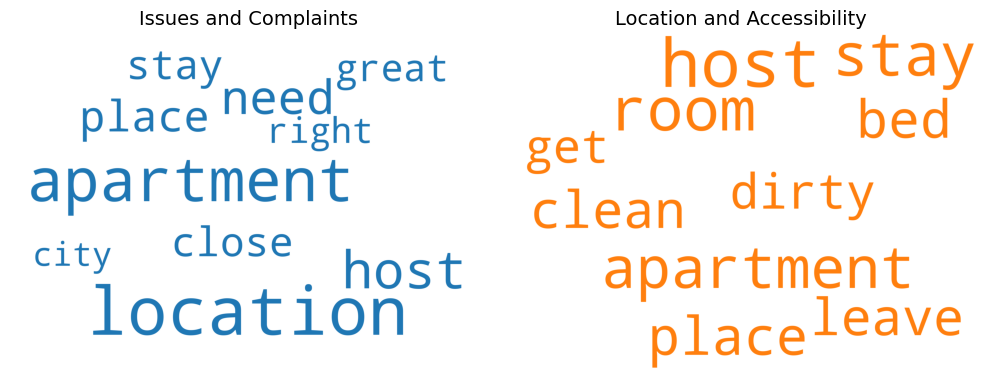

In [26]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Issues and Complaints',
          1: 'Location and Accessibility',
          2: 'Host and Service Experience'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=10)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [27]:
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalm,1,312
1,Södermalm,0,285
2,Kungsholmen,0,83
3,Kungsholmen,1,83
4,Norrmalm,1,78
5,Norrmalm,0,70
6,Enskede-Årsta-Vantör,0,39
7,Enskede-Årsta-Vantör,1,29
8,Hägersten-Liljeholmen,0,21
9,Hägersten-Liljeholmen,1,21


In [30]:
# Define a custom color mapping function
def get_tile_color(tile_path):
    # Get the name of the neighbourhood and the dominant topic from the tile path
    neighbourhood, dominant_topic = tile_path[-2:]

    # Assign a specific color to each combination of neighbourhood and dominant topic
    if dominant_topic == 'topic 0' and neighbourhood == 'Neighbourhood 1':
        return 'red'
    elif dominant_topic == 'topic 1' and neighbourhood == 'Neighbourhood 2':
        return 'green'
    else:
        # Use the default color scale for all other tiles
        return None

# Create the treemap with the custom color mapping function
fig = px.treemap(
    numnber_topic_by_neighbourhood,
    path=['neighbourhood', 'dominant_topic'],
    values='number_of_reviews',
    color_discrete_sequence=PALETTE,
    color_continuous_midpoint=np.average(numnber_topic_by_neighbourhood['number_of_reviews']),
)

# Apply the custom color mapping function to each tile
fig.data[0].marker.colors = [get_tile_color(tile_path) for tile_path in fig.data[0].ids]

# Show the figure
fig.show()